### Importing Data and required Packages

In [26]:
# Packages
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import re

import warnings
warnings.filterwarnings("ignore")

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context = 'notebook' , style = 'whitegrid' , palette = 'Set1')
%matplotlib inline

# SKlearn

import category_encoders
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import silhouette_visualizer

from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

random_state = 42

## Get Data

In [27]:
df=pd.read_csv('./data.csv').drop(columns=['Unnamed: 0'])
# df.head()

## Take a Quick Look at the Data Structure

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              2651 non-null   object 
 1   brand             2651 non-null   object 
 2   2G                2651 non-null   bool   
 3   3G                2651 non-null   bool   
 4   4G                2651 non-null   bool   
 5   5G                2651 non-null   bool   
 6   Announced         2651 non-null   float64
 7   Status            2651 non-null   object 
 8   Weight            2651 non-null   float64
 9   Length            2651 non-null   object 
 10  Width             2651 non-null   object 
 11  Diameter          2651 non-null   object 
 12  SIM               2651 non-null   object 
 13  Display Type      2651 non-null   object 
 14  Display Size      2651 non-null   float64
 15  ppi               2651 non-null   float64
 16  body ratio        2651 non-null   float64


In [29]:
df.describe()

,Announced,Weight,Display Size,ppi,body ratio,battery_capacity,Price,CPU,pixel,RAM,Storage
count,2651.000000,2651.000000,2651.000000,2651.000000,2651.000000,2651.000000,2651.000000,2372.000000,2.651000e+03,2651.000000,2651.000000
mean,2016.577518,190.389325,5.759838,312.312335,71.775556,3385.437948,242.896775,5.847808,1.576779e+06,2.901974,46.621613
std,3.656827,97.208564,1.628346,101.907171,11.262514,1627.512406,193.726059,2.372880,1.181280e+06,2.493559,60.823522
min,2010.000000,89.300000,2.200000,121.000000,25.500000,50.000000,20.000000,2.000000,7.680000e+04,0.062500,0.039062
25%,2014.000000,140.100000,4.700000,233.000000,64.650000,2070.000000,130.000000,4.000000,5.184000e+05,1.000000,8.000000
50%,2016.000000,167.000000,5.500000,288.000000,71.400000,3000.000000,190.000000,8.000000,1.094400e+06,2.000000,16.000000
75%,2020.000000,195.000000,6.530000,400.000000,81.800000,4500.000000,290.000000,8.000000,2.527200e+06,4.000000,64.000000
max,2024.000000,950.000000,14.600000,807.000000,94.100000,11560.000000,2000.000000,10.000000,8.294400e+06,16.000000,512.000000


### Required Functions 

#### Proccessing some Features

In [30]:
def extract_display_type(input_string):

    input_string = re.sub(r'LCD[2356]', 'LCD', input_string)
    input_string = re.sub(r'S-LCD|SLCD', 'Super LCD', input_string)
    input_string = re.sub(r'S-IPS|SIPS', 'Super IPS', input_string)
    input_string = re.sub(r' or [^)]*', '', input_string)
    input_string = re.sub(r'Super clear |SC-', 'Super Clear ', input_string)
    input_string = re.sub(r'HD IPS\+|HD IPS \+|HD-IPS \+|HD IPS Plus', 'IPS', input_string)
    input_string = re.sub(r'TFT  LCD', 'TFT LCD', input_string)
    input_string = re.sub(r'IPS\+', 'IPS', input_string)
    input_string = re.sub(r'[^)]*IPS LCD', 'IPS LCD', input_string)
    input_string = re.sub(r'P-OLED', 'OLED', input_string)
    input_string = re.sub(r'True |Samsung |Plus| LTPO|LTPO2|LTPO | resistive touchscreen|2X|-NEO| XDR|Clear |3D|-backlit|Foldable |Curved |Flexible ', '', input_string)
    input_string = re.sub(r'Super Retina|Dynamic', '', input_string)

 
    input_string = input_string.split(',')[0].strip()

    if input_string in ['Super IPS', 'IPS']:
        input_string = 'IPS LCD'
    if input_string in ['TN TFT LCD', 'TFT']:
        input_string = 'TFT LCD'
    if input_string in ['TN', 'TDDI', 'LED LCD', 'PLS', 'PLS LCD', 'Liquid Retina mini-LED LCD']:
        input_string='LCD'


    return input_string
# Sensors
def pre_sensors(x):
       
    if (x == x) & (x !='Yes'):
        x = x.lower()
        parentheses_pattern = r'\(.*?\)'
        dash_pattern= r'-.*?,'
        cleaned_sensors = re.sub(parentheses_pattern, '', x)
        cleaned_sensors = re.sub(dash_pattern, ',', cleaned_sensors)
        cleaned_sensors = re.sub(r'-.*', '', cleaned_sensors)

        cleaned_sensors = cleaned_sensors.replace("fingerprints", "fingerprint")
        cleaned_sensors = cleaned_sensors.replace("fingerprint ", "fingerprint")

        cleaned_sensors = cleaned_sensors.replace("dual fingerprint", "fingerprint")
        cleaned_sensors = cleaned_sensors.replace(" ,", ",")
        cleaned_sensors = cleaned_sensors.replace(", ", ",")
        cleaned_sensors = cleaned_sensors.replace("unspecified sensors", "")
       
        return cleaned_sensors
    return x

# Bluetooth
def pre_bluetooth(x):
        
        result=re.findall(r'(\d+.\d)',x)
        if result:
            return result[0]
        return np.nan

#### handling Outliers Functions

In [31]:
def drop_outliers_IQR(df, column_name, fillna=False):
    df = df.copy()
    distance = 1.5 * (np.percentile(df[column_name], 75) - np.percentile(df[column_name], 25))

    if fillna:
        df.loc[df[column_name] > distance + np.percentile(df[column_name], 75), column_name] = distance + np.percentile(df[column_name], 75)
        df.loc[df[column_name] < np.percentile(df[column_name], 25) - distance, column_name] = np.percentile(df[column_name], 25) - distance
    else:
        df.loc[df[column_name] > distance + np.percentile(df[column_name], 75), column_name] = np.nan
        df.loc[df[column_name] < np.percentile(df[column_name], 25) - distance, column_name] = np.nan

    return df[column_name]

def drop_outliers_Zscore(df, column_name, fillna=False):
    df = df.copy()
    threshold = 3
    mean_value = df[column_name].mean()
    std_value = df[column_name].std()

    if fillna:
        df.loc[(df[column_name] <= mean_value - threshold * std_value), column_name] = -threshold * std_value
        df.loc[(df[column_name] >= mean_value + threshold * std_value), column_name] = threshold * std_value
    else:
        df[(df[column_name] <= mean_value - threshold * std_value) | (df[column_name] >= mean_value + threshold * std_value)] = np.nan

    return df[column_name]



    


## Preproccessing whole dataset

In [32]:
def PreProccess_df(data):
    # Network-------------------> map to 1 , 0

    data['2G'] = data['2G'].map({True:1, False:0})
    data['3G'] = data['3G'].map({True:1, False:0})
    data['4G'] = data['4G'].map({True:1, False:0})
    data['5G'] = data['5G'].map({True:1, False:0})
    
    # convert Lenght , Width dtype
    
    data['Length']=data['Length'].apply(lambda x: re.findall(r'[0-9.]{2,7}',x)[0]).astype('float64')
    data['Width']=data['Width'].apply(lambda x: re.findall(r'[0-9.]{2,7}',x)[0]).astype('float64')
    
    # Diameter ---------------> Process and Change dtype
    
    data['Diameter'] = data['Diameter'].apply(lambda col: col.split('-')[0]).astype('float64')
    
    # Display Type ----------------> Change into Types
    
    data['Display Type'] = data['Display Type'].apply(extract_display_type)
    
    # OS-----------------> divide into two groups ('New_OS','OS_version')
    
    data[['OS','OS_version']]=data.OS.str.split(' ',expand=True)
    
    data['OS']=data['OS'].apply(lambda x: 'iOS' if x in ['iOS','iPadOS'] else x)
    data['OS']=data['OS'].apply(lambda x: 'Other' if x not in ['Android','iOS'] else x)
    data['OS_version']=data['OS_version'].apply(lambda x: np.nan if (x=='OS') or (x== None) else x) 
    
    # WLAN---------------> Preproccess and fill nan with mode value of each brand
    data['WLAN']=data.WLAN.str.split(' ',expand=True)[0].str.split(',',expand=True)[0].apply(lambda x: 'Wi-Fi' if x=='Yes' else x)
    
    # Sensors--------------------------> 
    
    #Total Sensors--------> list in order to see all sensors  in mobiles
    sensor_list=list(data.Sensors.unique())
    result_list=[]
    for sensor in sensor_list:
        if (sensor == sensor) & (sensor !='Yes'):
            sensor = sensor.lower()
            parentheses_pattern = r'\(.*?\)'
            dash_pattern= r'-.*?,'
            cleaned_sensors = re.sub(parentheses_pattern, '', sensor)
            cleaned_sensors = re.sub(dash_pattern, ',', cleaned_sensors)
            cleaned_sensors = re.sub(r'-.*', '', cleaned_sensors)
            cleaned_sensors = cleaned_sensors.replace("fingerprints", "fingerprint")
            cleaned_sensors = cleaned_sensors.replace("dual fingerprint", "fingerprint")
            cleaned_s_list=cleaned_sensors.split(',')
            
            for item in cleaned_s_list:
                item=item.strip()
                result_list.append(item)
                
    All_sensors=list(set(result_list))
    
    # Sensors--------------> Process and fill yes
    
    data['Sensors']=data.Sensors.apply(pre_sensors)
    data['Sensors']= data['Sensors'].apply(lambda x: np.nan if x == 'Yes' else x)
    
    sensors = data['Sensors'].apply(lambda x: x.strip() if x==x else x).str.get_dummies(sep=',')
    data = pd.concat([data, sensors], axis=1)

    # Bluetooth---------> Change into version
    
    data['Bluetooth']=data.Bluetooth.apply(pre_bluetooth)
    
    # Card slot ---------------> Change into type
    
    data['Card slot']=data['Card slot'].apply(lambda x: x.split(' ')[0].replace(',',''))
    data['Card slot']=data['Card slot'].apply(lambda x: np.nan if (x=='Unspecified') or (x=='Yes')  else x)

       
    # Chipset----------------> name of Chipset
     
    data['Chipset']=data.Chipset.str.split(' ',expand=True)[0]
    data['Chipset']=data['Chipset'].apply(lambda x: 'Exynos' if x == '5' else x)

    #  'Loudspeaker' , '3.5mm jack' -------------> map to 0,1
    data['Loudspeaker'] = data['Loudspeaker'].map({True:1, False:0})
    data['3.5mm jack'] = data['3.5mm jack'].map({True:1, False:0})
    
    ## drop unwanted columns
    # data.drop(['name','Colors','GPU','Network','OS','Sensors','Internal'],axis=1,inplace=True)
    data=data[['2G', '3G', '4G', '5G', 'Announced','Weight', 'Length', 'Width', 'Diameter',
               'Display Size', 'ppi', 'body ratio', 'battery_capacity', 'Price', 'CPU', 'pixel',
               'Loudspeaker', '3.5mm jack', 'RAM', 'Storage', 'accelerometer','altimeter', 
               'ambient light sensor', 'barometer', 'color spectrum','compass', 'face id',
               'face recognition', 'fingerprint', 'gesture','gyro', 'gyroscope', 'hand id',
               'heart rate', 'humidity', 'infrared face id', 'infrared thermometer', 'iris scanner',
               'proximity','sensor core', 'spo2', 'temperature', 'unspecified', 'uv','brand',
               'Status','SIM', 'Display Type','ratio','WLAN', 'Bluetooth',
               'Chipset','Card slot','OS','OS_version']]
    
    
    return data

In [33]:
data=df.copy()
data=PreProccess_df(data)
# data.info() 

In [34]:
data_battery_price_before=data[['battery_capacity', 'Price']]

data_battery_price_before.var()

battery_capacity    2.648797e+06
Price               3.752979e+04
dtype: float64

### Fill Nans of whole dataset

In [35]:
# filling nan

imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(data)
data_train = imputer.transform(data)

data = pd.DataFrame(data_train, columns=data.columns)
data[['2G', '3G', '4G', '5G', 'Announced', 'Weight', 'Length', 'Width',
       'Diameter', 'Display Size', 'ppi', 'body ratio', 'battery_capacity',
       'Price', 'CPU', 'pixel', 'Loudspeaker', '3.5mm jack', 'RAM', 'Storage',
       'accelerometer', 'altimeter', 'ambient light sensor', 'barometer',
       'color spectrum', 'compass', 'face id', 'face recognition',
       'fingerprint', 'gesture', 'gyro', 'gyroscope', 'hand id', 'heart rate',
       'humidity', 'infrared face id', 'infrared thermometer', 'iris scanner',
       'proximity', 'sensor core', 'spo2', 'temperature', 'unspecified', 'uv']]=data[['2G', '3G', '4G', '5G', 'Announced', 'Weight', 'Length', 'Width',
       'Diameter', 'Display Size', 'ppi', 'body ratio', 'battery_capacity',
       'Price', 'CPU', 'pixel', 'Loudspeaker', '3.5mm jack', 'RAM', 'Storage',
       'accelerometer', 'altimeter', 'ambient light sensor', 'barometer',
       'color spectrum', 'compass', 'face id', 'face recognition',
       'fingerprint', 'gesture', 'gyro', 'gyroscope', 'hand id', 'heart rate',
       'humidity', 'infrared face id', 'infrared thermometer', 'iris scanner',
       'proximity', 'sensor core', 'spo2', 'temperature', 'unspecified', 'uv']].astype('float64')


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   2G                    2651 non-null   float64
 1   3G                    2651 non-null   float64
 2   4G                    2651 non-null   float64
 3   5G                    2651 non-null   float64
 4   Announced             2651 non-null   float64
 5   Weight                2651 non-null   float64
 6   Length                2651 non-null   float64
 7   Width                 2651 non-null   float64
 8   Diameter              2651 non-null   float64
 9   Display Size          2651 non-null   float64
 10  ppi                   2651 non-null   float64
 11  body ratio            2651 non-null   float64
 12  battery_capacity      2651 non-null   float64
 13  Price                 2651 non-null   float64
 14  CPU                   2651 non-null   float64
 15  pixel                

#### Handling Outliers of battery capacity and price

In [37]:
# Removing outliers with zcscore

numeric_features = ['battery_capacity', 'Price']

for feature in numeric_features:
    data[feature] = drop_outliers_Zscore(data, feature,fillna=True)    
    # data = data.loc[~data[feature].isna(),:]


print(data.shape)


(2651, 55)


### Distributions of preprocessed Data set
#### histogram of battery and price

In [38]:
data_battery_price_after=data[['battery_capacity', 'Price']].copy().astype('float64')
# data_battery_price_after.battery_capacity.value_counts()
data_battery_price_after.var()

battery_capacity    2.140656e+06
Price               2.074494e+04
dtype: float64

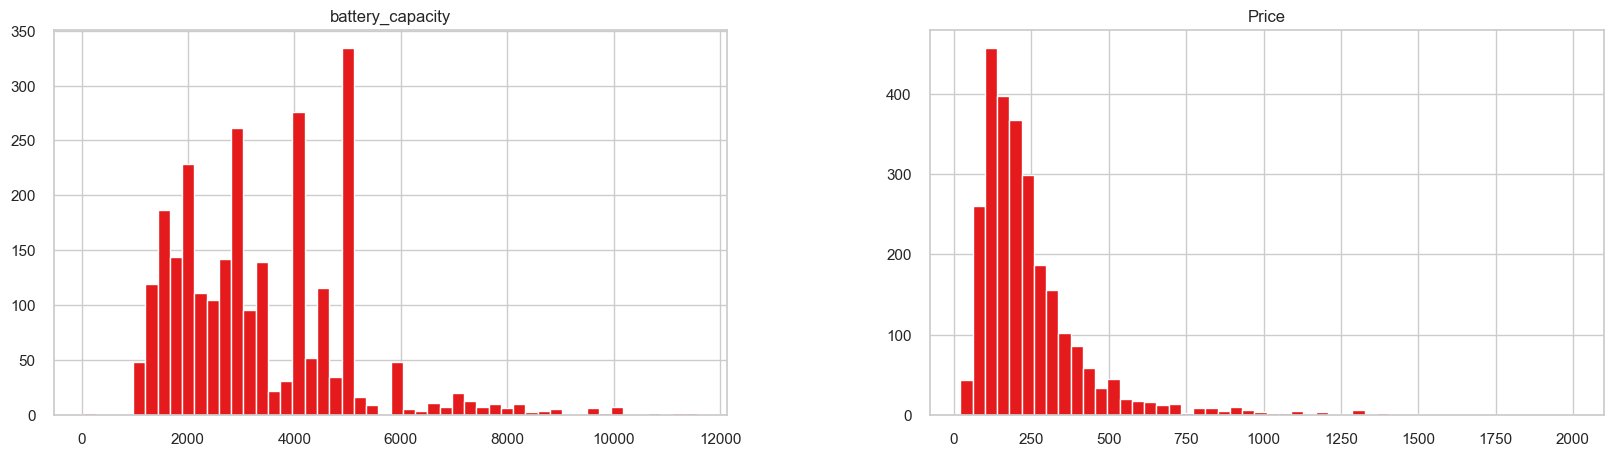

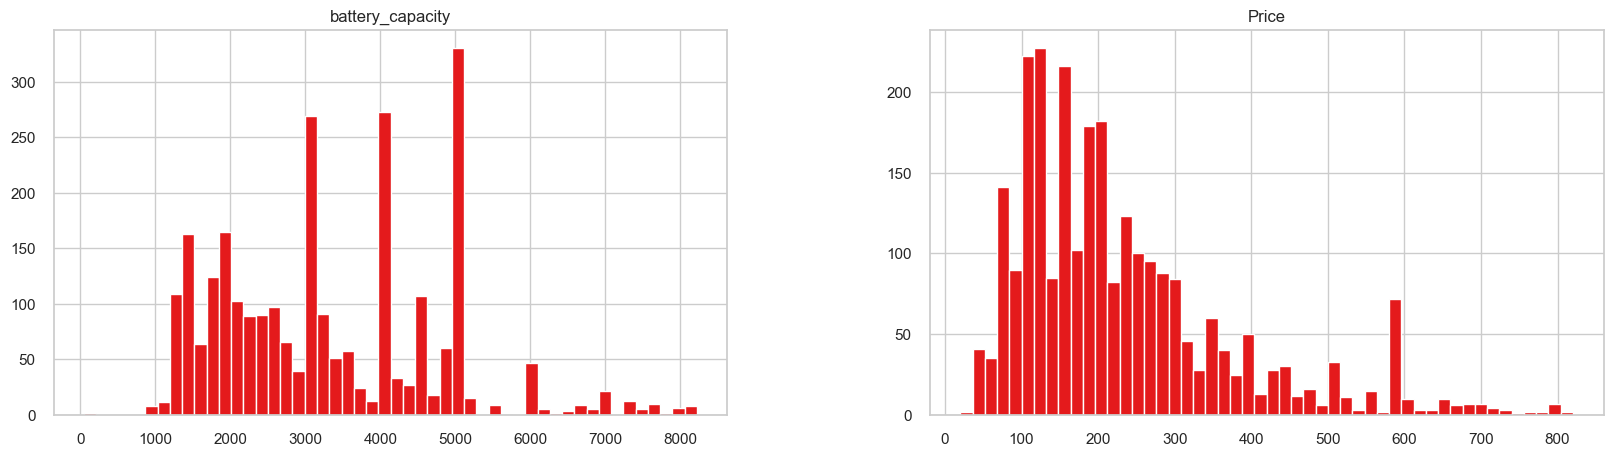

In [39]:
data_battery_price_before.hist(bins=50,figsize=(20,5))
plt.show();
data_battery_price_after.hist(bins=50,figsize=(20,5))
plt.show();

In [40]:
data_Q1=data_battery_price_after.copy()


## comparing data for two status: 1-before outliers handling , 2- after outliers handling

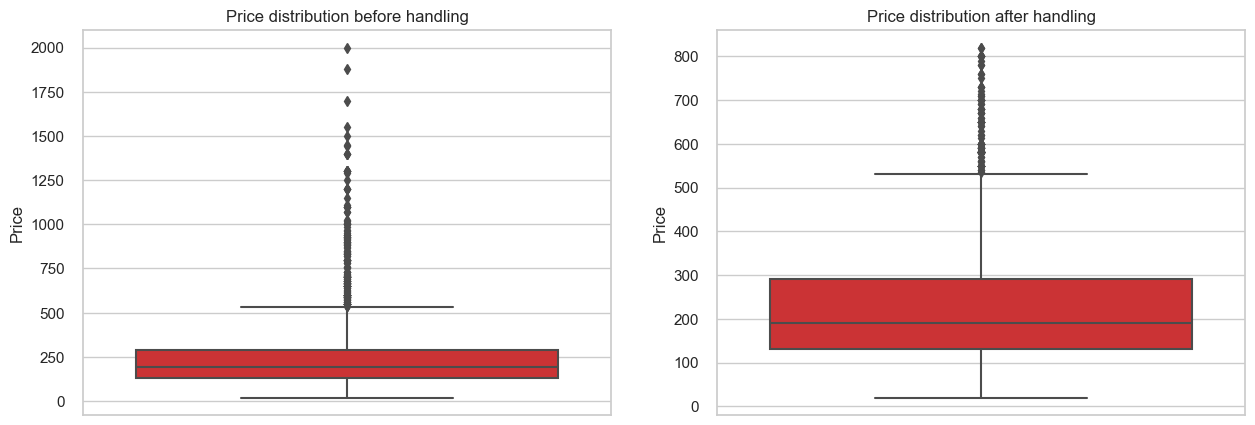

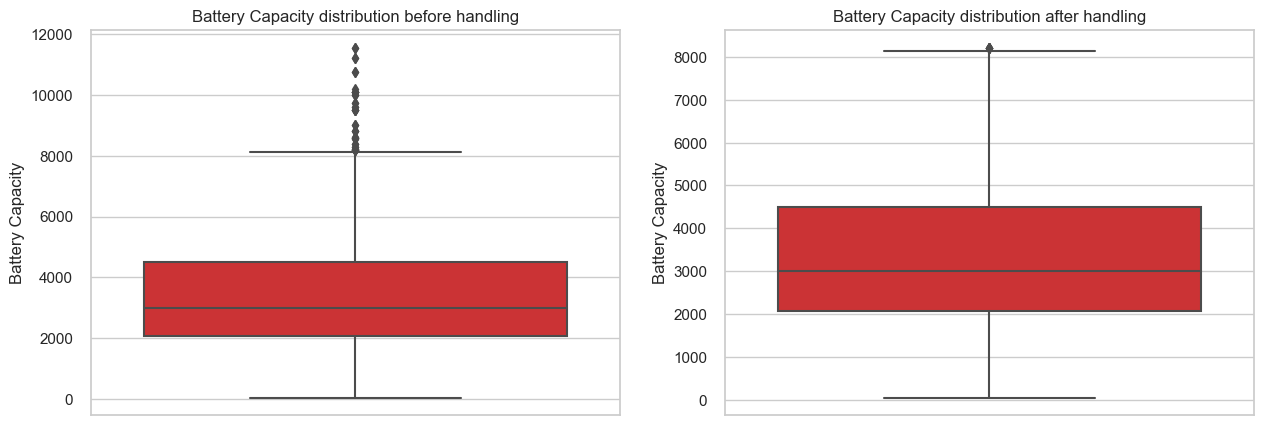

In [41]:


#### comparing

fig1, ax1=plt.subplots(1,2,figsize=(15,5))

sns.boxplot(y='Price', data=df, ax=ax1[0])
ax1[0].set_title('Price distribution before handling')
ax1[0].set_ylabel('Price')

sns.boxplot(y='Price', data=data_Q1, ax=ax1[1])
ax1[1].set_title('Price distribution after handling')
ax1[1].set_ylabel('Price')


fig2, ax2=plt.subplots(1,2,figsize=(15,5))

sns.boxplot(y='battery_capacity', data=df, ax=ax2[0])
ax2[0].set_title('Battery Capacity distribution before handling')
ax2[0].set_ylabel('Battery Capacity');

sns.boxplot(y='battery_capacity', data=data_Q1, ax=ax2[1])
ax2[1].set_title('Battery Capacity distribution after handling')
ax2[1].set_ylabel('Battery Capacity');

# Clustering

## part 1- KMeans

clusters are: (array([0, 1, 2, 3, 4]), array([104, 993, 309, 660, 585], dtype=int64))


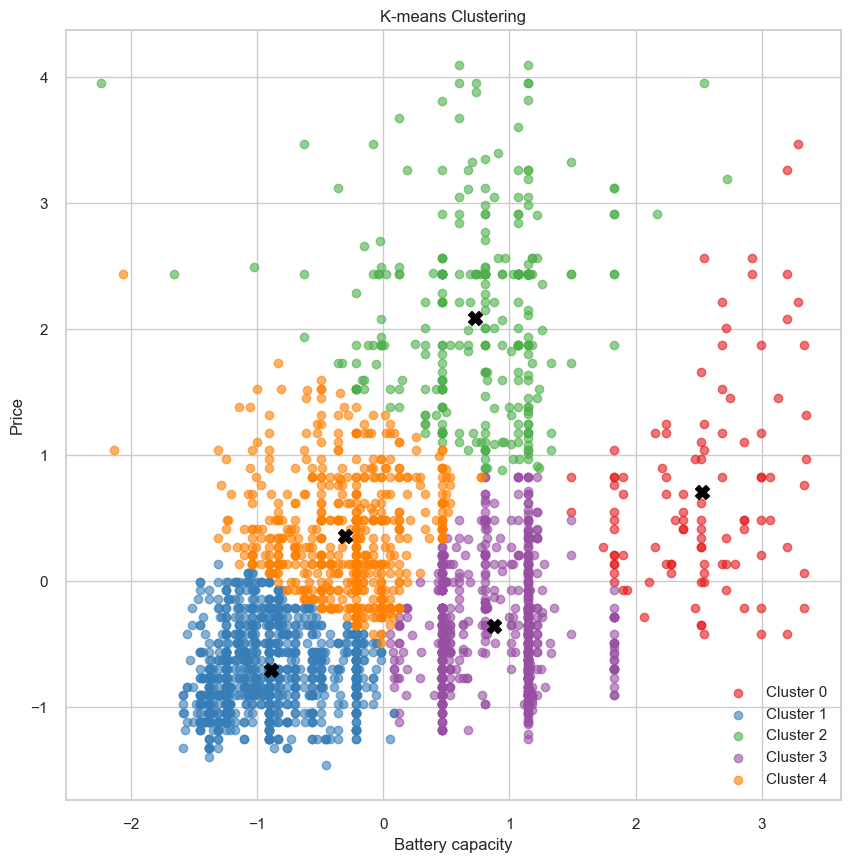

In [42]:
# with scaling data
data_P1=data_Q1.copy()

st = StandardScaler()
stdDf = pd.DataFrame(st.fit_transform(data_P1), columns=data_P1.columns)

data_P1=stdDf.copy()
features=list(data_P1.columns)
# KMeans

k_num=5 ##############################
kmeans = KMeans(n_clusters=k_num, random_state=42)
clusters = kmeans.fit_predict(data_P1)
data_P1['Cluster'] = clusters

print('clusters are:',np.unique(kmeans.labels_, return_counts=True))

plt.figure(figsize=(10, 10))
for i in range(k_num):
    cluster_data = data_P1[data_P1['Cluster'] == i]
    plt.scatter(cluster_data[features[0]], cluster_data[features[1]], label=f'Cluster {i}', alpha=0.6)
    
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='X', s=100, color='black')
    
plt.title('K-means Clustering')
plt.xlabel('Battery capacity')
plt.ylabel('Price')
plt.legend()

plt.show()


In [43]:
data_P1.reset_index()
df_P1_result=pd.concat([data,data_P1['Cluster']],axis=1)
df_P1_result=df_P1_result[['Display Size','pixel', 'ppi', 'body ratio', 'battery_capacity',
       'Price', 'CPU', 'RAM', 'Storage','brand', 'Status', 'SIM', 'Display Type','OS', 'Cluster']]

df_P1_cluster_0 = df_P1_result[df_P1_result['Cluster']==0]
df_P1_cluster_1 = df_P1_result[df_P1_result['Cluster']==1]
df_P1_cluster_2 = df_P1_result[df_P1_result['Cluster']==2]
df_P1_cluster_3 = df_P1_result[df_P1_result['Cluster']==3]
df_P1_cluster_4 = df_P1_result[df_P1_result['Cluster']==4]

for cluster_label in range(5):
    cluster_data = df_P1_result[df_P1_result['Cluster'] == cluster_label]
    most_brand_share=np.round(cluster_data['brand'].value_counts()[0]/len(cluster_data)*100)
    
    print(f"Cluster {cluster_label} Details:")
    print(f"Number of points in the cluster: {len(cluster_data)}")

    print()
    print(f"Most frequent brand: {cluster_data['brand'].mode().values[0]} with {most_brand_share}%")
    print(f"Most frequent status : {cluster_data['Status'].mode().values[0]}")
    print(f"Median of battery_capacity: {cluster_data['battery_capacity'].median()}")
    print(f"Median of Price: {cluster_data['Price'].median()}")
    print(f"Median of Display Size: {cluster_data['Display Size'].median()}")
    print(f"Most frequent PPI Resulation: {cluster_data['ppi'].mode().values[0]}")
    print(f"Most frequent CPU core: {cluster_data['CPU'].mode().values[0]}")
    print(f"Most frequent RAM: {cluster_data['RAM'].mode().values[0]}")
    print(f"Most frequent Storage: {cluster_data['Storage'].mode().values[0]}")

    print(f"-------------------------------")
    print()
    # cluster_data[['Display Size','ppi', 'body ratio', 'battery_capacity',
    #    'Price', 'CPU', 'RAM', 'Storage']].hist(bins=50 ,figsize=(15,10))
    # plt.show()


Cluster 0 Details:
Number of points in the cluster: 104

Most frequent brand: samsung with 38.0%
Most frequent status : Available
Median of battery_capacity: 7000.0
Median of Price: 300.0
Median of Display Size: 10.1
Most frequent PPI Resulation: 224.0
Most frequent CPU core: 8.0
Most frequent RAM: 4.0
Most frequent Storage: 16.0
-------------------------------

Cluster 1 Details:
Number of points in the cluster: 993

Most frequent brand: samsung with 18.0%
Most frequent status : Discontinued
Median of battery_capacity: 2000.0
Median of Price: 120.0
Median of Display Size: 4.5
Most frequent PPI Resulation: 233.0
Most frequent CPU core: 4.0
Most frequent RAM: 1.0
Most frequent Storage: 4.0
-------------------------------

Cluster 2 Details:
Number of points in the cluster: 309

Most frequent brand: samsung with 23.0%
Most frequent status : Available
Median of battery_capacity: 4500.0
Median of Price: 520.0
Median of Display Size: 6.67
Most frequent PPI Resulation: 395.0
Most frequent CP

## Part 2 - Optimal K

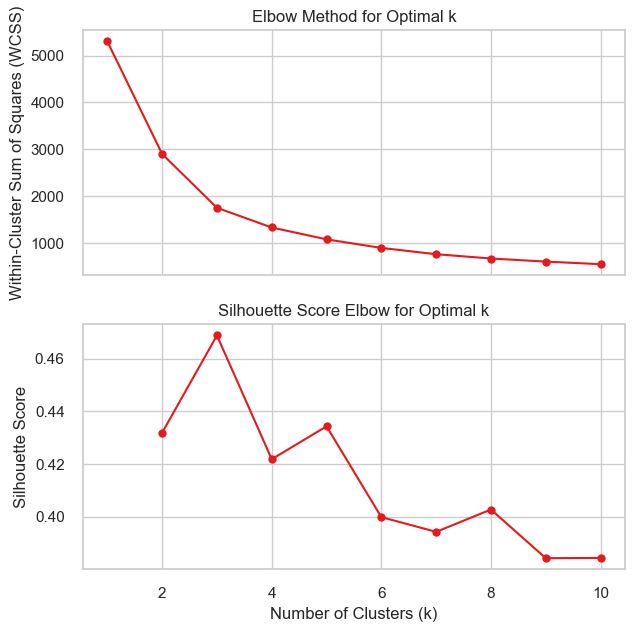

In [44]:
data_P2=data_Q1.copy()

# Scaling data

st = StandardScaler()
stdDf = pd.DataFrame(st.fit_transform(data_P2), columns=data_P2.columns)
data_P2=stdDf.copy()

# Elbow Method

fig, ax=plt.subplots(2,1,figsize=(7,7), sharex=True)
wcss = []
for k in range(1, 11):
    kmeans_elbow = KMeans(n_clusters=k, random_state=42)
    kmeans_elbow.fit(data_P2)
    wcss.append(kmeans_elbow.inertia_)
# plt.figure(figsize=(6, 3))
ax[0].plot(range(1, 11), wcss, marker='o')
ax[0].set_title('Elbow Method for Optimal k')
ax[0].set_ylabel('Within-Cluster Sum of Squares (WCSS)')

# Silhouette plot

points = []
for k in range(2, 11):
    kmeans_Silhouette = KMeans(n_clusters=k, random_state=42)
    kmeans_Silhouette.fit(data_P2)
    points.append(silhouette_score(data_P2, kmeans_Silhouette.labels_))
ax[1].plot(range(2, 11), points, marker='o')
ax[1].set_title('Silhouette Score Elbow for Optimal k')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')
plt.show()

 k = 3 بر طبق نمودار ها: بهترین حالت ممکن 

In [45]:
range_n_clusters= list(range(2,11))

num_clusters= []
sh_scores=[]
for n_clusters in range_n_clusters:
    clusterer= KMeans(n_clusters=n_clusters,random_state=42)
    cluster_labels = clusterer.fit_predict(data_P2)

    silhouette_avg= silhouette_score(data_P2,cluster_labels)
    print('for n_clusters = ',n_clusters,' The average silhouette_score is: ',silhouette_avg)

    #compare the silhoutte scores for each sample
    sample_silhoutte_values = silhouette_samples(data_P2,cluster_labels)
    num_clusters.append(n_clusters)
    sh_scores.append(silhouette_avg)
best_shs_index=np.argmax(sh_scores)

best_num_cluster=num_clusters[best_shs_index]
best_shscore=sh_scores[best_shs_index]
print('\n','---------------')
print(f'The optimum K value is {best_num_cluster} with the highest silhoutte score: {best_shscore}')
    

for n_clusters =  2  The average silhouette_score is:  0.4318945555739113
for n_clusters =  3  The average silhouette_score is:  0.468849078840397
for n_clusters =  4  The average silhouette_score is:  0.4218337304346508
for n_clusters =  5  The average silhouette_score is:  0.43431977563503865
for n_clusters =  6  The average silhouette_score is:  0.39983020110917694
for n_clusters =  7  The average silhouette_score is:  0.3942264561407334
for n_clusters =  8  The average silhouette_score is:  0.40271464505040844
for n_clusters =  9  The average silhouette_score is:  0.3842317793916292
for n_clusters =  10  The average silhouette_score is:  0.38431653098142343

 ---------------
The optimum K value is 3 with the highest silhoutte score: 0.468849078840397


## Part3- DBSCAN

# ---------

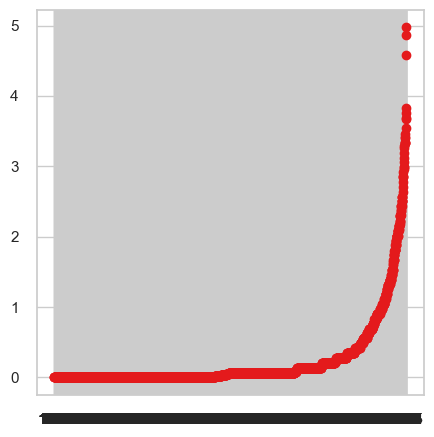

Considering mindistance between 0.1 to 0.6


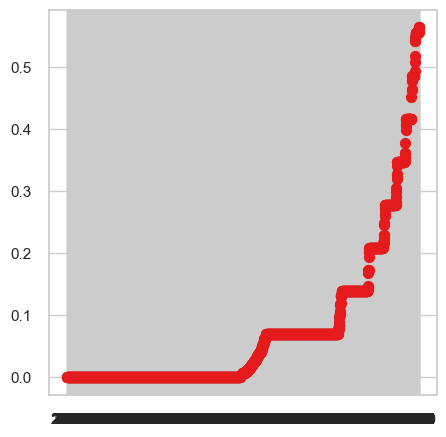

In [46]:
data_P3=data_Q1.copy()

# scaling data
st = StandardScaler()
MM = MinMaxScaler()

data_P3_std = pd.DataFrame(st.fit_transform(data_P3), columns=data_P3.columns)
# data_P3_MM = pd.DataFrame(MM.fit_transform(data_P3), columns=data_P3.columns)

data_P3=data_P3_std.copy()
data_P3 = data_P3.sort_values(by=['battery_capacity','Price'])

index_list=[]
distance_list=[]

for i in range (0 , len(data_P3)-1):
    
    dist=np.linalg.norm(data_P3.iloc[i]-data_P3.iloc[i+1])
    
    index_list.append(str(i))
    distance_list.append(dist)

df2 = pd.DataFrame({'index': index_list, 'distance':distance_list }) 
df2=df2.sort_values(by=['distance'])
plt.figure(figsize=(5,5))
plt.scatter(df2['index'],df2['distance'])
plt.show()

print('Considering mindistance between 0.1 to 0.6')
df3= df2[df2['distance']<0.6]
df3=df3.sort_values(by=['distance'])
plt.figure(figsize=(5,5))

plt.scatter(df3['index'],df3['distance'], s=50)
plt.show()


In [47]:
# Epsilon ---------------> init min_samples = 6
range_eps= list(np.round(np.arange(0.1,0.7,step=0.05),3))

for i in range_eps:
    print('eps value is '+str(i))
    db=DBSCAN(eps=i,min_samples=6).fit(data_P3)
    core_samples_mask=np.zeros_like(db.labels_,dtype=bool)
    core_samples_mask[db.core_sample_indices_]=True
    labels= db.labels_
    print(set(labels))
    silhouette_avg=silhouette_score(data_P3,labels)
    print('for eps value='+str(i),labels,'The average silhoutte_score is :',silhouette_avg)
    print()
    

eps value is 0.1
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, -1}
for eps value=0.1 [-1 -1 -1 ... -1 -1 -1] The average silhoutte_score is : 0.07524384010737203

eps value is 0.15
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
for eps value=0.15 [-1 -1 -1 ... -1 -1 -1] The average silhoutte_score is : -0.07721570713966476

eps value is 0.2
{0, 1, 2, 3, 4, 5, 6, 7, -1}
for eps value=0.2 [-1 -1 -1 ... -1 -1 -1] The average silhoutte_score is : 0.14175116766171345

eps value is 0.25
{0, 1, 2, 3, 4, -1}
for eps value=0.25 [-1 -1 -1 ... -1 -1 -1] The average silhoutte_score is : 0.20398306012868195

eps value is 0.3
{0, 1, 2, -1}
for eps value=0.3 [-1 -1 -1 ... -1 -1 -1] The average silhoutte_score is : 0.322681541030715

eps value is 0.35
{0, 1, -1}
for eps value=0.35 [-1 -1 -1 ... -1  0 -1] The average silhoutte_score is : 0.5126691712240317

eps value is 0.4
{0, -1}
for eps value=0.4 [-1 -1 -1 ... -1  0  0] The average silhoutte_score is : 0.5269035617687535

ep

In [48]:
# Min_samples --------------------->eps=0.3
eps=0.3

min_samples=list(range(1,30))
for i in min_samples:
    print('min_samples value is '+str(i))
    db= DBSCAN(eps=eps,min_samples=i).fit(data_P3)
    core_samples_mask=np.zeros_like(db.labels_,dtype=bool)
    core_samples_mask[db.core_sample_indices_]= True

    labels= set([label for label in db.labels_ if label >=0])
    print(set(labels))
    print('For min_samples value='+str(i),'Total no. of clusters are '+ str(len(set(labels))))
    print()

min_samples value is 1
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
For min_samples value=1 Total no. of clusters are 23

min_samples value is 2
{0, 1, 2, 3, 4, 5, 6, 7, 8}
For min_samples value=2 Total no. of clusters are 9

min_samples value is 3
{0, 1, 2, 3, 4}
For min_samples value=3 Total no. of clusters are 5

min_samples value is 4
{0, 1, 2, 3, 4, 5}
For min_samples value=4 Total no. of clusters are 6

min_samples value is 5
{0, 1, 2}
For min_samples value=5 Total no. of clusters are 3

min_samples value is 6
{0, 1, 2}
For min_samples value=6 Total no. of clusters are 3

min_samples value is 7
{0, 1}
For min_samples value=7 Total no. of clusters are 2

min_samples value is 8
{0, 1}
For min_samples value=8 Total no. of clusters are 2

min_samples value is 9
{0, 1}
For min_samples value=9 Total no. of clusters are 2

min_samples value is 10
{0, 1}
For min_samples value=10 Total no. of clusters are 2

min_samples value is 11
{0, 1, 2}
For min_s

In [49]:
####################################
# Compute DBSCAN
eps=0.3
min_samples=7
db=DBSCAN(eps=eps,min_samples=min_samples).fit(data_P3)
core_Sample_mask= np.zeros_like(db.labels_,dtype=bool)
core_samples_mask[db.core_sample_indices_]=True
labels = db.labels_
print(set(labels))

data_P3['cluster']=labels
n_clusters_= len(set(labels))
n_noise_=list(labels).count(-1)

print(np.unique(db.labels_, return_counts=True))

print('Estimated number of clusters:%d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print(f'DBScan parameters are: Epsilon = {eps}, min_samples = {min_samples}')

{0, 1, -1}
(array([-1,  0,  1], dtype=int64), array([  62, 2489,  100], dtype=int64))
Estimated number of clusters:3
Estimated number of noise points: 62
DBScan parameters are: Epsilon = 0.3, min_samples = 7


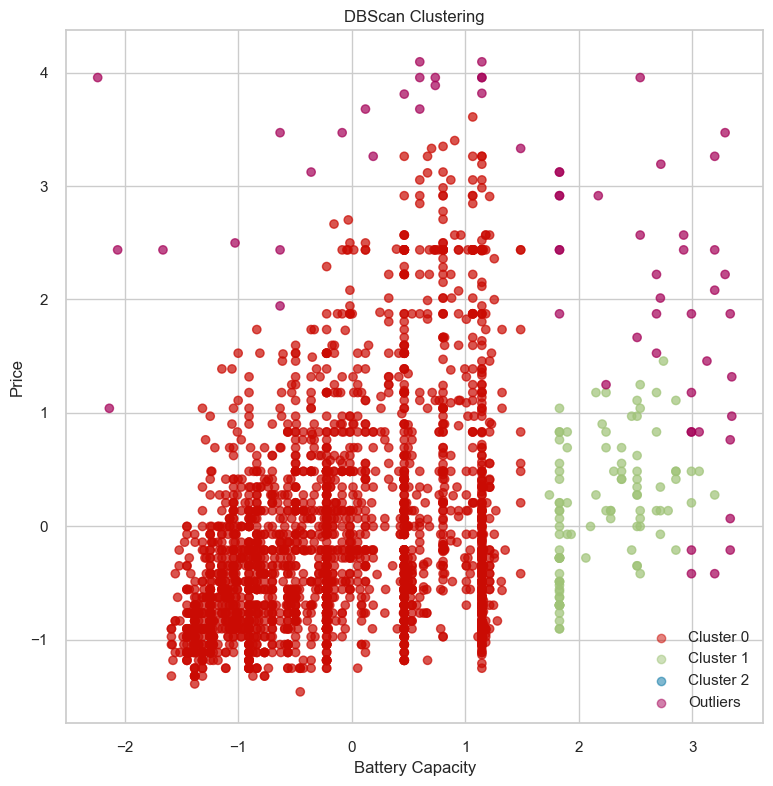

In [52]:
# Building the Label to colour mapping
colours ={}
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[-1] ='m'

# Building the colour vector for each data point
cvec = [colours[label] for label in labels]

plt.figure(figsize=(9,9))

# r = plt.scatter(data_P3['battery_capacity'],data_P3['Price'], color = 'r',alpha = 0.5);
# g = plt.scatter(data_P3['battery_capacity'],data_P3['Price'], color = 'g',alpha = 0.5);
# b = plt.scatter(data_P3['battery_capacity'],data_P3['Price'], color = 'b',alpha = 0.5);
# m = plt.scatter(data_P3['battery_capacity'],data_P3['Price'], color = 'm',alpha = 0.5);

# Ploting P1 on the X-Axis and P2  on the Y-Axis
#according to the colour vector defined

plt.scatter(data_P3['battery_capacity'],data_P3['Price'], c = cvec, alpha = 0.7)
plt.title('DBScan Clustering')
plt.xlabel('Battery Capacity')
plt.ylabel('Price')

#bulding the legend
plt.legend((r,g,b, m),('Cluster 0','Cluster 1','Cluster 2','Outliers'))
plt.show()

In [53]:
data_P3.reset_index()
df_P3_result=pd.concat([data,data_P3['cluster']],axis=1)
df_P3_result=df_P3_result[['Announced','Display Size', 'ppi', 'battery_capacity',
       'Price', 'CPU', 'RAM', 'Storage','brand', 'Status', 'SIM', 'Display Type','OS', 'cluster']]


for cluster_label in range(-1,2):
    cluster_data = df_P3_result[df_P3_result['cluster'] == cluster_label]
    most_brand_share=np.round(cluster_data['brand'].value_counts()[0]/len(cluster_data)*100)
    most_status_share=np.round(cluster_data['Status'].value_counts()[0]/len(cluster_data)*100)

    
    print(f"Cluster {cluster_label} Details:")
    print(f"Number of points in the cluster: {len(cluster_data)}")
    print()
    
    print(f"Most frequent brand: {cluster_data['brand'].mode().values[0]} with {most_brand_share}%")
    print(f"Most frequent status : {cluster_data['Status'].mode().values[0]} with {most_status_share}%")

    print(f"Median of battery_capacity: {cluster_data['battery_capacity'].median()}")
    print(f"Median of Price: {cluster_data['Price'].median()}")
    print(f"Median of Display Size: {cluster_data['Display Size'].median()}")
    print(f"Most frequent PPI Resulation: {cluster_data['ppi'].mode().values[0]}")
    print(f"Most frequent CPU core: {cluster_data['CPU'].mode().values[0]}")
    print(f"Most frequent RAM: {cluster_data['RAM'].mode().values[0]}")
    print(f"Most frequent Storage: {cluster_data['Storage'].mode().values[0]}")

    print(f"-------------------------------")
    print()

Cluster -1 Details:
Number of points in the cluster: 62

Most frequent brand: samsung with 26.0%
Most frequent status : Available with 79.0%
Median of battery_capacity: 6550.0
Median of Price: 581.1781764512631
Median of Display Size: 10.1
Most frequent PPI Resulation: 400.0
Most frequent CPU core: 8.0
Most frequent RAM: 4.0
Most frequent Storage: 128.0
-------------------------------

Cluster 0 Details:
Number of points in the cluster: 2489

Most frequent brand: samsung with 19.0%
Most frequent status : Discontinued with 53.0%
Median of battery_capacity: 3000.0
Median of Price: 190.0
Median of Display Size: 5.5
Most frequent PPI Resulation: 294.0
Most frequent CPU core: 8.0
Most frequent RAM: 1.0
Most frequent Storage: 16.0
-------------------------------

Cluster 1 Details:
Number of points in the cluster: 100

Most frequent brand: samsung with 37.0%
Most frequent status : Available with 57.0%
Median of battery_capacity: 6510.0
Median of Price: 250.0
Median of Display Size: 9.85
Most